In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from python.analysis import cross_section, Plots, Tags
from apps import cex_toy_generator
from apps import cex_fit_studies

toy_config = {
  "events": 100000,
  "step": 2,
  "p_init": 2000,
  "beam_profile": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/beam_profile/beam_profile.json",
  "beam_width": 60,
  "smearing_params": {
    "KE_init": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/smearing/KE_init/double_crystal_ball.json",
    "KE_int": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/smearing/KE_int/double_crystal_ball.json",
    "z_int": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/smearing/z_int/double_crystal_ball.json"
  },
  "reco_region_fractions": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/reco_regions/moderate_efficiency_reco_region_fractions.hdf5",
  "beam_selection_efficiencies": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
  "mean_track_score_kde": "/home/bhuller/Projects/pi0-analysis/analysis/work/2023/analysis_final_KE_lim/toy_parameters/meanTrackScoreKDE/kdes.dill",
  "pdf_scale_factors": None,
  "df_format": "f",
  "modified_PDFs": None,
  "verbose": False,
  "seed": 1,
  "max_cpus": 21
}


def make_cfg(seed : int | None = None, modified_PDFs : list[np.ndarray] | None = None, events : int = int(1E5)) -> dict:
    """ Overwrite the default toy config file and make a new one.

    Args:
        seed (int | None, optional): seed of RNG. Defaults to None.
        modified_PDFs (list[np.ndarray] | None, optional): modified cross section curves. Defaults to None.
        events (int, optional): number of events to generate. Defaults to int(1E5).

    Returns:
        dict: New config.
    """
    cfg = {k : v for k, v in toy_config.items()}
    cfg["seed"] = seed
    cfg["modified_PDFs"] = modified_PDFs
    cfg["events"] = events
    return cfg


def contruct_true_reco_mapping(region_num : np.ndarray, KE_int_reco : np.ndarray, KE_int_true  : np.ndarray, region_bins : list[int], reco_bins : list[float], true_bins : list[float]) -> np.ndarray:
    """ Create the mapping of how counts in true energy bin end up in each reco bin (reco bin is both in region and energy.)

    Args:
        region_num (np.ndarray): region number for each event.
        KE_int_reco (np.ndarray): Reconstructed interacting KE.
        KE_int_true (np.ndarray): True interacting KE.
        region_bins (list[int]): Region number bins.
        reco_bins (list[float]): Reconstructed interacting KE bins.
        true_bins (list[float]): True interacting KE bins.

    Returns:
        np.ndarray: 3D matrix with dimensions (region bins, reco bins, true bins). Slicing the matric in true bins tells you how those events migrate to the reco bins. 
    """
    # returns a correlation matrix that tells you how many events in a true energy bin are also in a reco KE bin and region.
    bins = (region_bins, reco_bins, true_bins)
    data = [np.array(region_num), np.array(KE_int_reco), np.array(KE_int_true)]

    H = np.histogramdd(data, bins)[0]

    # axis 0 is region[0]reco_bin[0], region[0]reco_bin[1], region[1]reco_bin[0], region[1]reco_bin[0], ...
    # axis 1 is true_bins[0], ...
    H_flat = np.reshape(H, ((len(bins[1]) - 1) * (len(bins[0]) - 1), len(bins[2]) - 1), order = "C")
    return np.array(H_flat, dtype = int)


def make_sample(proc : str, t : int, r : int, value : int) -> dict:
    """ Make a sample entry for the PyHF model.

    Args:
        proc (str): process (signal) name
        t (int): true bin index
        r (int): reco bin index
        value (int): value of the yield in this bin.

    Returns:
        dict: Sample entry.
    """
    return {
        "name" : f"{proc}_{r}_{t}",
        "data" : [value],
        "modifiers" : [
            {'name': f"mu_{proc}_{t}", 'type': 'normfactor', 'data': None},
        ]
    }


def make_model_jc(ai : cross_section.AnalysisInput, region_bins : list[int], reco_bins : list[float], true_bins : list[float]) -> cross_section.pyhf.Model:
    """ Create a likelihood model akin to Jake Calcutts design.
        #! add statistical nuisances
        #! add background sample

    Args:
        ai (cross_section.AnalysisInput): Template to construct model from.
        region_bins (list[int]): Region number bins.
        reco_bins (list[float]): Reconstructed interacting KE bins.
        true_bins (list[float]): True interacting KE bins.

    Returns:
        cross_section.pyhf.Model: PyHF model.
    """
    # binning really important, add nuisance parameters later
    region_num = np.sum([(i + 1) * ai.regions[r] for i, r in enumerate(ai.region_labels)], 0)
    unclassified = ~np.any([v for v in ai.regions.values()], axis = 0)

    tags = cross_section.Tags.ExclusiveProcessTags(None)

    mats = {tags[k].name_simple : contruct_true_reco_mapping(region_num[v], ai.KE_int_reco[v], ai.KE_int_true[v], region_bins, reco_bins, true_bins) for k, v in ai.exclusive_process.items()}

    n_channels = (len(reco_bins) - 1) * (len(region_bins) - 1)

    channels = []
    first_poi = None
    for r in range(n_channels): # looping over each channel
        samples = [] # note sample and true energy bins are flattened to one index
        for s in mats: # loop over samples
            for t, v in enumerate(mats[s][r]): # loop over true energy bins
                samples.append(make_sample(s, t, r, v))
                if first_poi is None:
                    first_poi = f"mu_{s}_{t}"
        channels.append({"name" : f"channel_{r}", "samples" : samples})

    return cross_section.pyhf.Model({"channels" : channels}, poi_name = first_poi)


def make_observations(ai : cross_section.AnalysisInput, true_bins : np.ndarray, reco_bins : np.ndarray, model : cross_section.pyhf.Model) -> np.ndarray:
    """ Contruct the array of observations to fit to the likelihood model made in make_model_jc.

    Args:
        ai (cross_section.AnalysisInput): observation sample (i.e. data).
        true_bins (np.ndarray): True interacting KE bins.
        reco_bins (np.ndarray): Reconstructed interacting KE bins.
        model (cross_section.pyhf.Model): PyHF mocel.

    Returns:
        np.ndarray: Observations in each bin, sorted in the way expected by the PyHF model. 
    """
    unclassified = ~np.any([v for v in ai.regions.values()], axis = 0)

    in_range_reco = (ai.KE_int_reco >= min(reco_bins)) & (ai.KE_int_reco <= max(reco_bins))
    in_range_true = (ai.KE_int_true >= min(true_bins)) & (ai.KE_int_true <= max(true_bins))

    in_range = in_range_reco & in_range_true # for data, this can only be in_range_reco, so need to resolve this somehow...

    observations = []
    observations.append(np.histogram(ai.KE_int_reco[unclassified & in_range], reco_bins)[0])
    for r in ai.region_labels:
        observations.append(np.histogram(ai.KE_int_reco[ai.regions[r] & in_range], reco_bins)[0])

    observations = np.array(observations).flatten()

    order = [int(c.split("_")[-1]) for c in model.config.channels] # cause pyhf sucks

    scale_factor = sum(model.expected_actualdata(model.config.suggested_init())) / sum(in_range)

    return scale_factor * observations[order]


def asimov_test(model : cross_section.pyhf.Model) -> cross_section.FitResults:
    """ Fit the template to itself i.e. contruct observations from the template as well.

    Args:
        model (cross_section.pyhf.Model): PyHD model.

    Returns:
        cross_section.FitResults: Fit results.
    """
    obs = model.expected_data(model.config.suggested_init())
    fit_result = cross_section.RegionFit.Fit(obs, model, model.config.suggested_init(), par_bounds = [[0, np.inf]] * len(model.config.par_names))
    plot_fit_results(fit_result, model)
    return fit_result


def plot_fit_results(fit_result : cross_section.FitResults, model : cross_section.pyhf.Model):
    """ Plot the fit results. Specifically the fitted values and the correlation matrix of the POIs.

    Args:
        fit_result (cross_section.FitResults): fit result.
        model (cross_section.pyhf.Model): PyHF model.
    """
    Plots.Plot(fit_result.bestfit, model.config.par_names, xlabel = "best fit", ylabel = "POI", xerr = fit_result.uncertainty, linestyle = "", marker = "o", color = "k")
    Plots.plt.yticks(model.config.par_names, model.config.par_names)
    Plots.plt.axvline(1, linestyle = "--", color = "red")
    Plots.plt.xlim(0, 2)

    cmat = fit_result.corr_mat
    Plots.plt.figure()
    Plots.plt.imshow(cmat, origin = "lower", cmap = "coolwarm")
    Plots.plt.xticks(range(len(model.config.par_names)), model.config.par_names, fontsize = "small", rotation = 30)
    Plots.plt.yticks(range(len(model.config.par_names)), model.config.par_names, fontsize = "small")
    Plots.plt.grid(False)
    Plots.plt.colorbar()
    
    for (i, j), z in np.ndenumerate(fit_result.corr_mat):
        plt.gca().text(j, i, f"{round(z, 2)}", ha='center', va='center', fontsize = "x-small")
    return


def Effective_distance():
    """ Plot effective distance for the enregy slice method, for a given set of slice thicknesses
    """
    widths = [10, 25, 50, 100, 150, 200, 250]
    Plots.plt.figure()
    for w in widths:
        energy_slices = cross_section.Slices(w, 0, 2000, reversed = True)
        slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
        Plots.Plot(energy_slices.pos, energy_slices.width / slice_dEdX, xlabel = "Start KE at slice (MeV)", ylabel = "Distance travelled in slice (cm)", newFigure = False, label = f"{w} MeV")
    plt.axhline(0.5, color = "black", linestyle = "--", label = "Simulation step size (cm)")
    plt.axhline(106.6, color = "black", linestyle = "-.", label = "$\pi^{\pm}$-Ar interaction length (cm)")
    plt.legend(ncols = 4, loc = "upper center")
    Plots.plt.yticks(np.linspace(0, 125, (125//25) + 1, True))
    # Plots.plt.ylim(0, 1.1 * max(Plots.plt.gca().get_ylim()))
    Plots.plt.ylim(0, 130)


def binomial_variance(n_s : np.ndarray, n : np.ndarray) -> np.ndarray:
    """ Calculate binomial vairance (assuming two sample only)

    Args:
        n_s (np.ndarray): signal counts.
        n (np.ndarray): Total counts.

    Returns:
        np.ndarray: Variance.
    """
    return n_s * (1 - cross_section.nandiv(n_s, n))


def create_hists(ai : cross_section.AnalysisInput, energy_slices : cross_section.SlicesVar, scale_factors : dict[tuple[float, float]], method : int = 0) -> tuple[tuple, tuple, dict]:
    """ Do the counting experiment, and scale the counts based on some scale factors provided i.e. from the fit.
        Uses two different methods:
        method 0: scale only the exclusive interacting counts.
        methof 1: scale the exclusive interacting counts, then recalculate the total interactions and incident counts. 

    Args:
        ai (cross_section.AnalysisInput): Sample to do counting experiment with.
        energy_slices (cross_section.SlicesVar): Energy slices.
        scale_factors (dict[tuple[float, float]]): scale factors of the interacting histogram. Should not include the overflow/underflow bins.
        method (int, optional): method to use when applying the scale factors. Defaults to 0.

    Returns:
        tuple[tuple, tuple, dict]: total interacting counts (and errors), incident counts (and errors), exclusive interacting counts (and errors). 
    """
    ints = {i : cross_section.EnergySlice.CountingExperiment(ai.KE_int_true, ai.KE_init_true, ai.outside_tpc_true, ai.exclusive_process[i], energy_slices, True) for i in ai.process_labels}
    init, inel, _, inc = cross_section.EnergySlice.CountingExperiment(ai.KE_int_true, ai.KE_init_true, ai.outside_tpc_true, ai.exclusive_process["absorption"], energy_slices)

    if scale_factors:
        scaled_int = {k: scale_factors[k][0] * v[1:-1] for k, v in ints.items()}
    else:
        scaled_int = {k : v[1:-1] for k, v in ints.items()}

    if method == 1: # recalculate inel and inc based on the new scaled interactions
        inel = np.sum([v for v in scaled_int.values()], 0)
        inc = cross_section.EnergySlice.NIncident(init[1:-1], inel)
        # return inel, inc, scaled_int
        return (inel[1:-1], None), (inc[1:-1], None), {k: (v, None) for k, v in scaled_int.items()} #! figure this out!
    else: # don't recalculate inel and inc (just scale int)
        inel_err = binomial_variance(inel[1:-1], inc[1:-1])**0.5
        inc_err = inc[1:-1]**0.5

        scaled_int_err = {k: scaled_int[k] * ((scale_factors[k][1]/scale_factors[k][0])**2 + (binomial_variance(v[1:-1], inc[1:-1])/(v[1:-1])**2))**0.5 for k, v in ints.items()}

        return (inel[1:-1], inel_err), (inc[1:-1], inc_err), {k: (v, scaled_int_err[k]) for k, v in scaled_int.items()}


def get_scale_factors(fit_result : cross_section.FitResults, model : cross_section.pyhf.Model) -> dict[tuple[float, float]]:
    """ Convert the fit results into scale factors dictionary.

    Args:
        fit_result (cross_section.FitResults): Likelihood fit result
        model (cross_section.pyhf.Model): PyHF model.

    Returns:
        dict[tuple[float, float]]: dictionary of the best fit values and their uncertainties.
    """
    tags = Tags.ExclusiveProcessTags(None)

    scale_factors = {k : [[], []] for k in tags.name.values}
    for k, v, e in zip(model.config.par_names, fit_result.bestfit, fit_result.uncertainty):
        name = k.split("_")[1]
        scale_factors[tags.name_simple[name].name][0].append(v)
        scale_factors[tags.name_simple[name].name][1].append(e)
    scale_factors = {k : np.array([v[0][::-1], v[1][::-1]]) for k, v in scale_factors.items()}
    return scale_factors


def xs_closure(ai : cross_section.AnalysisInput, energy_slices : cross_section.SlicesVar, scale_factors : dict[list[float]] | None = None, mod_pdf = None, method : int = 0):
    """ Measure the cross cross section and make a plot comparing this to the GEANT4 simulation and if provided, the modified cross sections.

    Args:
        ai (cross_section.AnalysisInput): Sample to measure cross section with (i.e. the template or MC)
        energy_slices (cross_section.SlicesVar): Energy slices.
        scale_factors (dict[list[float]] | None, optional): Interacting count scale factors. Defaults to None.
        mod_pdf (_type_, optional): Modified cross sections. Defaults to None.
        method (int, optional): Method to do the counting experiment with. Defaults to 0.
    """
    inel, inc, ints = create_hists(ai, energy_slices, scale_factors, method)
    slice_dedx = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid("211"))[:-1]

    for _, i in Plots.IterMultiPlot(ai.exclusive_process):
        xs = cross_section.EnergySlice.CrossSection(ints[i][0], inel[0], inc[0], slice_dedx, energy_slices.width[:-1][::-1], ints[i][1], inel[1], inc[1])
        cross_section.PlotXSComparison({"measured" : xs}, energy_slices, i, simulation_label = "GEANT4 v10.6", newFigure = False, chi2 = False)
        if mod_pdf:
            if (i == "single_pion_production") and ("double_charge_exchange" in mod_pdf):
                Plots.Plot(mod_pdf["KE"], mod_pdf["double_charge_exchange"] + mod_pdf["quasielastic"], label = "modified xs", newFigure = False)
            elif i in mod_pdf:
                Plots.Plot(mod_pdf["KE"], mod_pdf[i], label = "modified xs", newFigure = False)
    return


def toy_test(toy_template : cross_section.AnalysisInput, toy_obs : cross_section.AnalysisInput, true_bins : list[float], reco_bins : list[float], region_bins : list[int], mod_xs : dict[np.ndarray]):
    """ Run the fit and cross section measurement using toy data and MC.

    Args:
        toy_template (cross_section.AnalysisInput): Toy MC sample.
        toy_obs (cross_section.AnalysisInput): Toy data sample.
        reco_bins (list[float]): Reconstructed interacting KE bins.
        true_bins (list[float]): True interacting KE bins.
        region_bins (list[int]): Region number bins.
        mod_xs (dict[np.ndarray]): Modified cross sections used to generate the toy data sample.
    """
    model = make_model_jc(toy_template, region_bins, reco_bins, true_bins)
    observations = make_observations(toy_obs, true_bins, reco_bins, model)

    fit_result = cross_section.RegionFit.Fit(observations, model, model.config.suggested_init(), par_bounds = [[0, np.inf]] * len(model.config.par_names))
    plot_fit_results(fit_result, model)

    energy_slices = cross_section.SlicesVar(ak.Array(reversed(true_bins)))
    scale_factors = get_scale_factors(fit_result, model)
    xs_closure(toy_template, energy_slices, scale_factors, mod_xs, 0)
    return


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/bhuller/Projects/pi0-analysis/analysis


## Checking maximum energy slice size

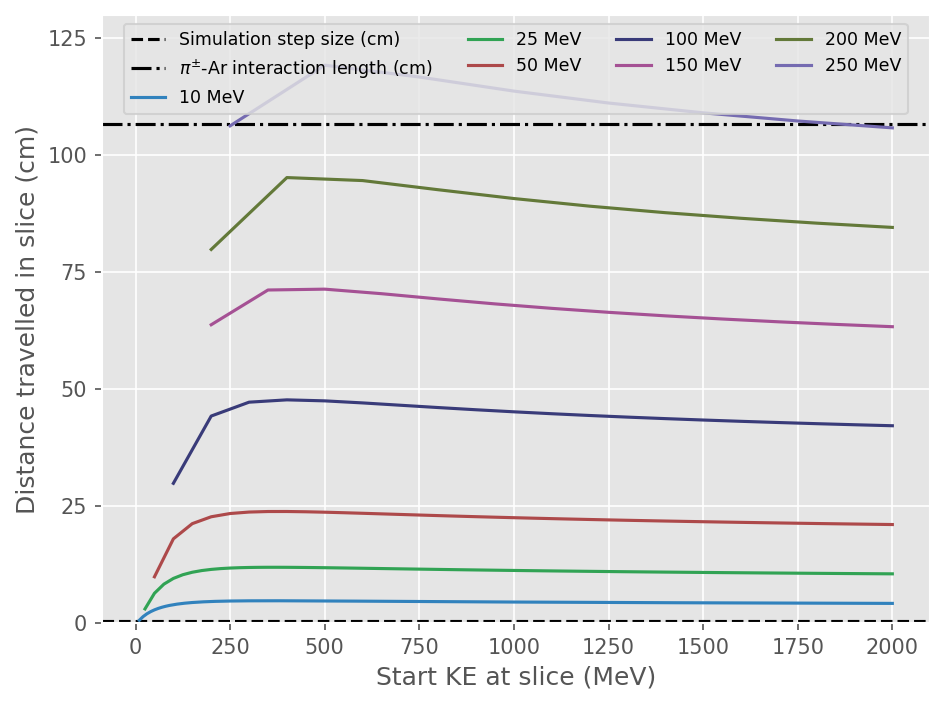

In [24]:
cross_section.SetPlotStyle(dark = True, dpi = 150)
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_final_KE_lim/analysis_config.json"))
Effective_distance()


## Asimov test

In [25]:
ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(make_cfg())))
# ai = cross_section.AnalysisInput.FromFile(args.analysis_input["mc"])

Simulating |████████████████████████████████████████| 1/1 [100%] in 4.7s (0.21/s) 


'BeamSelectionEfficiency' executed in 0.0143s

'GenerateRecoRegions' executed in 0.1908s

'MeanTrackScore' executed in 0.6780s

'main' executed in 6.0528s

init_params=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
poi_ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
parameter=['mu_abs_0', 'mu_abs_1', 'mu_abs_2', 'mu_abs_3', 'mu_cex_0', 'mu_cex_1', 'mu_cex_2', 'mu_cex_3', 'mu_pip_0', 'mu_pip_1', 'mu_pip_2', 'mu_pip_3', 'mu_spip_0', 'mu_spip_1', 'mu_spip_2', 'mu_spip_3']
bestfit=array([1.        , 0.99999999, 0.99999998, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])
uncertainty=array([0.1331738 , 0.17429319, 0.2320817 , 0.11748035, 0.10416451,
       0.11345941, 0.12974909, 0.06218788, 0.07753664, 0.07205852,
       0.0701309 , 0.02826708, 0.0677646 , 0.07451809, 0.08341531,
       0.03931202])
result=FitResults(bestfit=array([1.        , 0.99999999, 0.99999998, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.      

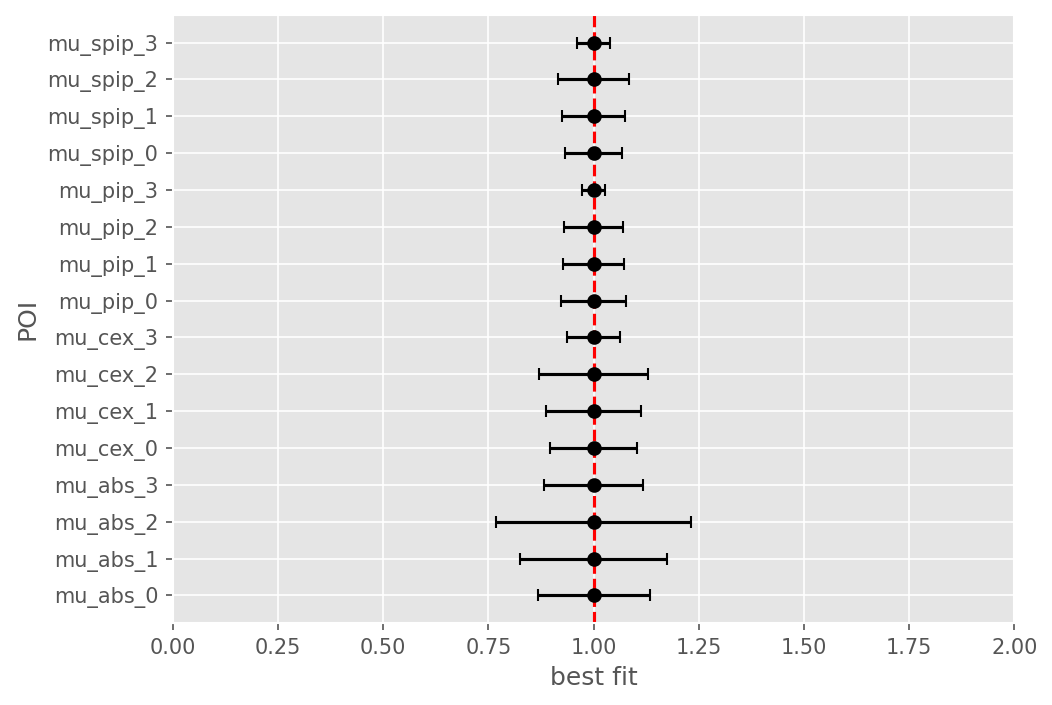

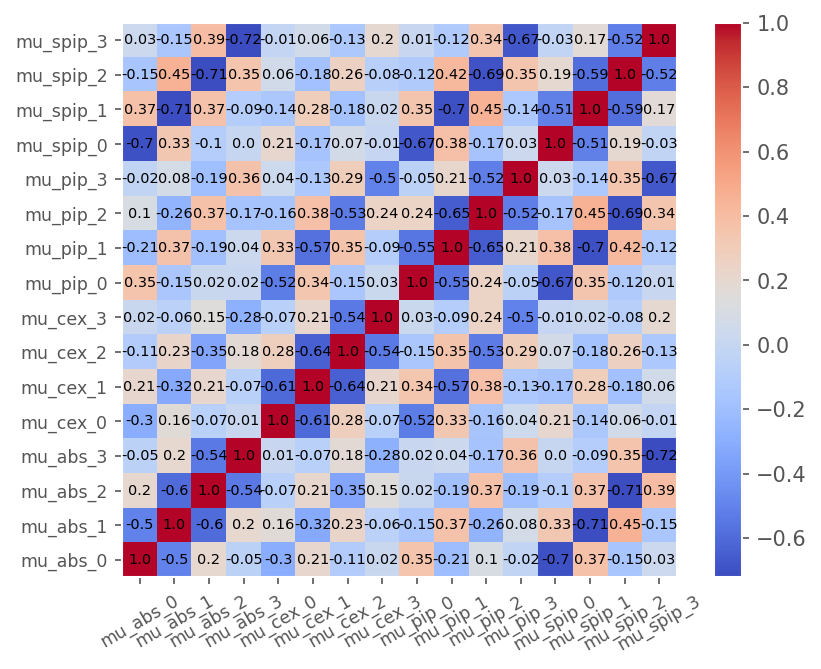

In [26]:
region_bins = [0, 1, 2, 3, 4, 5] # this has to be fixed to the number of reconstructed regions (+ unclassified)
reco_bins = [1300, 1500, 1650, 1750, 2000]
true_bins = [1300, 1500, 1650, 1750, 2000]
# reco_bins = [1350, 1500, 1650, 1800, 1950]
# true_bins = [1350, 1500, 1650, 1800, 1950]

model = make_model_jc(ai, region_bins, reco_bins, true_bins)
fit_result = asimov_test(model)

In [27]:
# ai_cheat = cross_section.AnalysisInput.FromFile(args.analysis_input["mc_cheated"])
ai_cheat = ai

In [ ]:
scale_factors = get_scale_factors(fit_result, model)

SyntaxError: invalid syntax (3837747907.py, line 1)

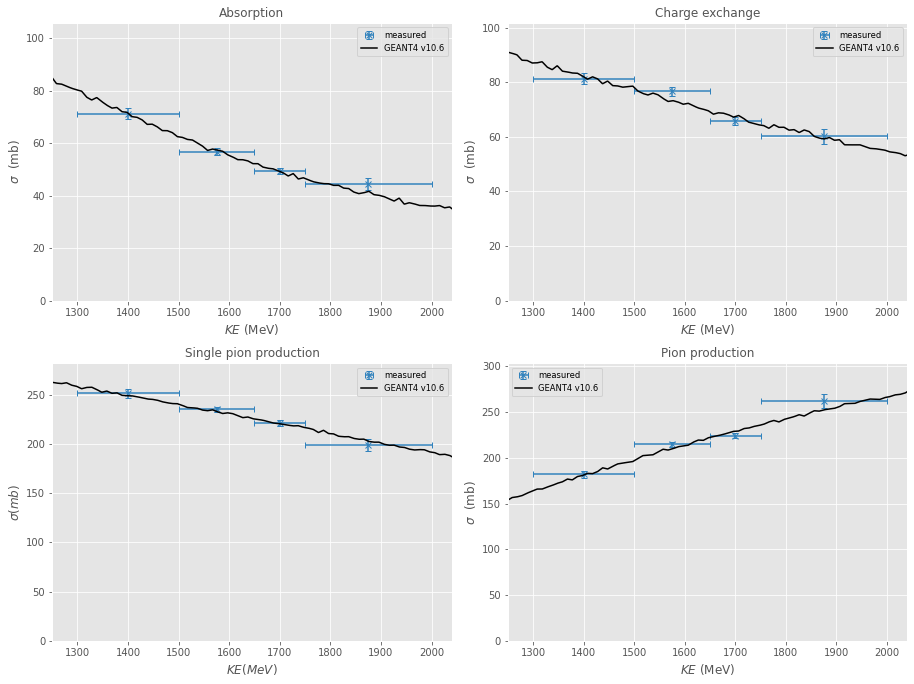

In [ ]:
energy_slices = cross_section.SlicesVar(ak.Array(reversed(true_bins)))

xs_closure(ai_cheat, energy_slices, scale_factors, None, 1)

## Toy study varying cross sections

In [ ]:
region_bins = [0, 1, 2, 3, 4, 5] # this has to be fixed to the number of reconstructed regions (+ unclassified)
reco_bins = [1300, 1500, 1650, 1800, 2000]
true_bins = [1300, 1500, 1650, 1800, 2000]

toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(make_cfg(1, None, int(1E6)))))

Simulating |████████████████████████████████████████| 5/5 [100%] in 37.3s (0.13/s) 


'BeamSelectionEfficiency' executed in 0.0551s

'GenerateRecoRegions' executed in 2.3785s

'MeanTrackScore' executed in 4.7167s

'main' executed in 48.9226s

Simulating |████████████████████████████████████████| 1/1 [100%] in 4.0s (0.25/s) 


'BeamSelectionEfficiency' executed in 0.0055s

'GenerateRecoRegions' executed in 0.1096s

'MeanTrackScore' executed in 0.4366s

'main' executed in 4.7789s

init_params=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
poi_ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
parameter=['mu_abs_0', 'mu_abs_1', 'mu_abs_2', 'mu_abs_3', 'mu_cex_0', 'mu_cex_1', 'mu_cex_2', 'mu_cex_3', 'mu_pip_0', 'mu_pip_1', 'mu_pip_2', 'mu_pip_3', 'mu_spip_0', 'mu_spip_1', 'mu_spip_2', 'mu_spip_3']
bestfit=array([1.08099107, 0.91697307, 1.32970736, 1.12928298, 0.90920474,
       1.03952721, 1.06828749, 0.91030193, 0.96307653, 0.97345589,
       1.00710257, 0.95409579, 1.01703262, 0.9680925 , 0.96614669,
       1.03134604])
uncertainty=array([0.04674993, 0.05347763, 0.04752346, 0.0527111 , 0.02876564,
       0.02979446, 0.02499603, 0.02440432, 0.02416088, 0.01947464,
       0.01345874, 0.01149183, 0.02176328, 0.02140934, 0.01722019,
       0.01728288])
result=FitResults(bestfit=array([1.08099107, 0.91697307, 1.32970736, 1.12928298, 0.90920474,
       1.03952721, 1.06828749, 0.91030193, 0.96307653, 0.97345589,
       1.007102

'BeamSelectionEfficiency' executed in 0.0094s

'GenerateRecoRegions' executed in 0.1865s

'MeanTrackScore' executed in 0.6428s

'main' executed in 4.9489s

init_params=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
poi_ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
parameter=['mu_abs_0', 'mu_abs_1', 'mu_abs_2', 'mu_abs_3', 'mu_cex_0', 'mu_cex_1', 'mu_cex_2', 'mu_cex_3', 'mu_pip_0', 'mu_pip_1', 'mu_pip_2', 'mu_pip_3', 'mu_spip_0', 'mu_spip_1', 'mu_spip_2', 'mu_spip_3']
bestfit=array([1.07203367, 0.87147952, 1.0636888 , 0.98119672, 0.97193181,
       1.02847986, 1.27771666, 1.16534184, 0.8675526 , 1.02542183,
       1.00347722, 0.93354371, 1.02514944, 0.96356009, 0.96204312,
       1.01209748])
uncertainty=array([0.04645609, 0.05286151, 0.04688185, 0.0521521 , 0.02894017,
       0.03022971, 0.02585076, 0.02548287, 0.02392022, 0.01944332,
       0.01350097, 0.01154179, 0.02156026, 0.02121693, 0.01710065,
       0.01715288])
result=FitResults(bestfit=array([1.07203367, 0.87147952, 1.0636888 , 0.98119672, 0.97193181,
       1.02847986, 1.27771666, 1.16534184, 0.8675526 , 1.02542183,
       1.003477

'BeamSelectionEfficiency' executed in 0.0096s

'GenerateRecoRegions' executed in 0.1916s

'MeanTrackScore' executed in 0.6625s

'main' executed in 6.8945s

init_params=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
poi_ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
parameter=['mu_abs_0', 'mu_abs_1', 'mu_abs_2', 'mu_abs_3', 'mu_cex_0', 'mu_cex_1', 'mu_cex_2', 'mu_cex_3', 'mu_pip_0', 'mu_pip_1', 'mu_pip_2', 'mu_pip_3', 'mu_spip_0', 'mu_spip_1', 'mu_spip_2', 'mu_spip_3']
bestfit=array([1.15445108, 0.84562783, 0.98869425, 0.70974212, 0.92628855,
       0.93801371, 1.06381918, 0.89191013, 0.83063701, 0.99288278,
       0.96152854, 0.90245521, 0.89633001, 0.93550964, 1.1046272 ,
       1.33132201])
uncertainty=array([0.04569529, 0.05280492, 0.04759968, 0.05359415, 0.0281233 ,
       0.02931908, 0.0249025 , 0.02445756, 0.02342552, 0.01932211,
       0.01352846, 0.01164245, 0.02110833, 0.02137034, 0.01764094,
       0.01800954])
result=FitResults(bestfit=array([1.15445108, 0.84562783, 0.98869425, 0.70974212, 0.92628855,
       0.93801371, 1.06381918, 0.89191013, 0.83063701, 0.99288278,
       0.961528

'BeamSelectionEfficiency' executed in 0.0098s

'GenerateRecoRegions' executed in 0.2611s

'MeanTrackScore' executed in 0.5083s

'main' executed in 6.2323s

init_params=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
poi_ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
parameter=['mu_abs_0', 'mu_abs_1', 'mu_abs_2', 'mu_abs_3', 'mu_cex_0', 'mu_cex_1', 'mu_cex_2', 'mu_cex_3', 'mu_pip_0', 'mu_pip_1', 'mu_pip_2', 'mu_pip_3', 'mu_spip_0', 'mu_spip_1', 'mu_spip_2', 'mu_spip_3']
bestfit=array([1.00781412, 0.94220907, 0.95447644, 0.82132412, 0.95883779,
       0.87465002, 1.09628299, 0.86556439, 0.73665284, 1.07069023,
       1.11084956, 1.18467609, 0.99995484, 0.84991705, 0.95222302,
       0.9803117 ])
uncertainty=array([0.04516231, 0.05143351, 0.04595662, 0.051644  , 0.02804072,
       0.02917153, 0.02512515, 0.02491935, 0.02325705, 0.01926321,
       0.01361366, 0.01195945, 0.020949  , 0.02075359, 0.01698176,
       0.01742218])
result=FitResults(bestfit=array([1.00781412, 0.94220907, 0.95447644, 0.82132412, 0.95883779,
       0.87465002, 1.09628299, 0.86556439, 0.73665284, 1.07069023,
       1.110849

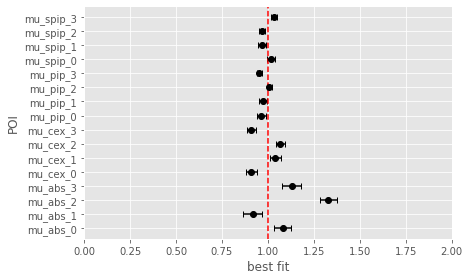

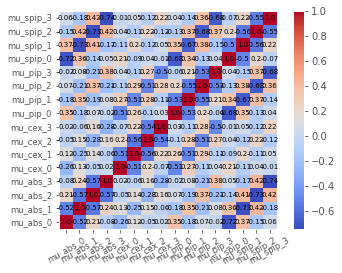

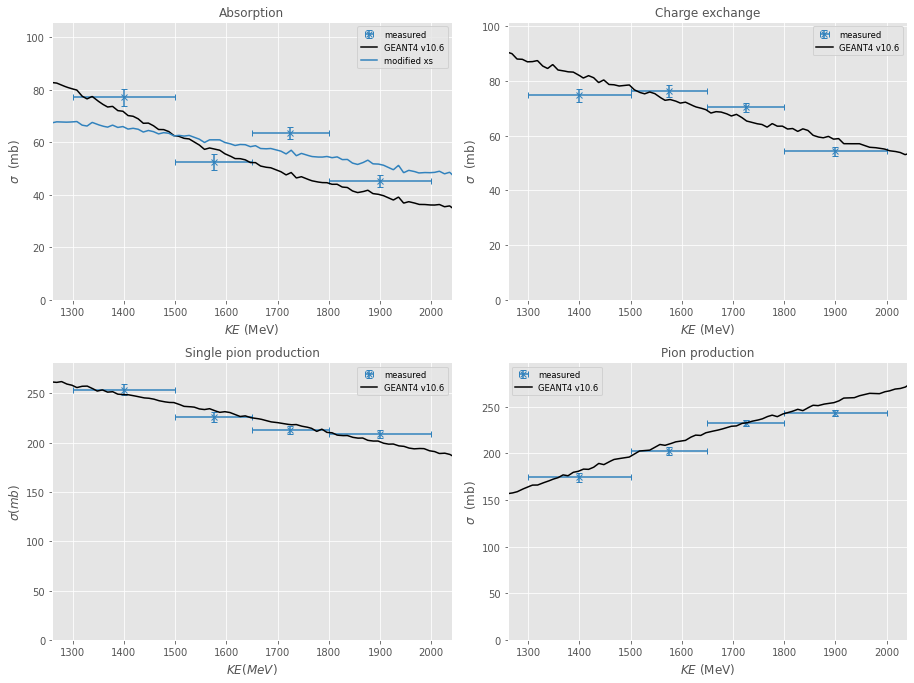

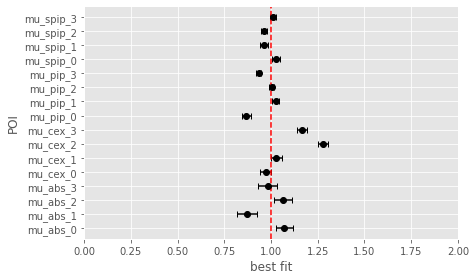

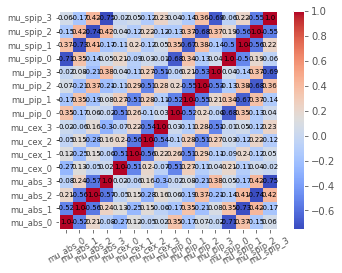

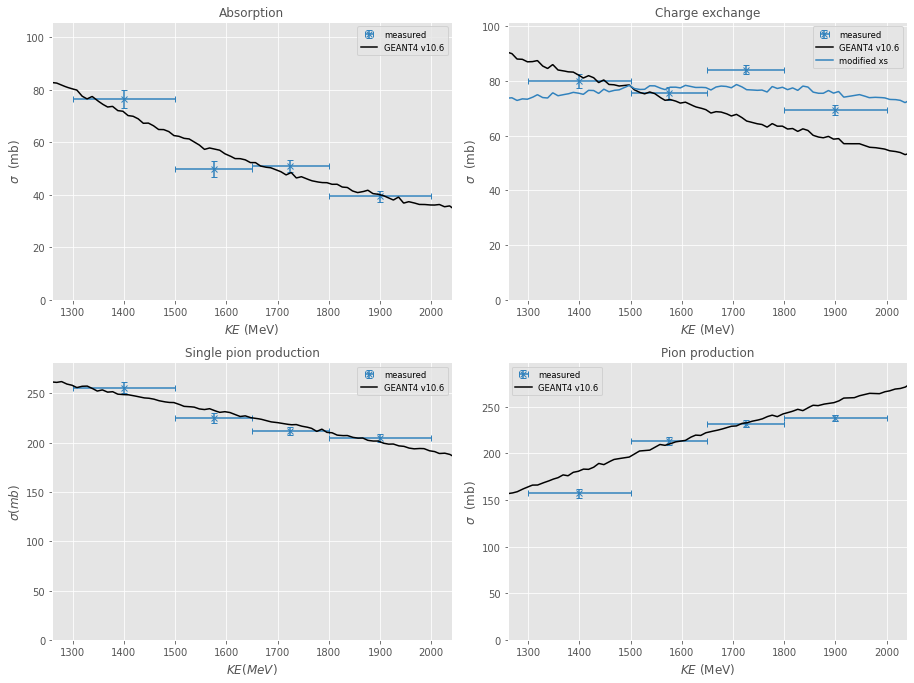

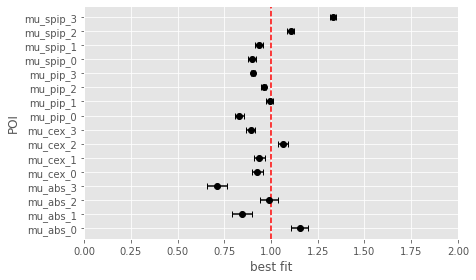

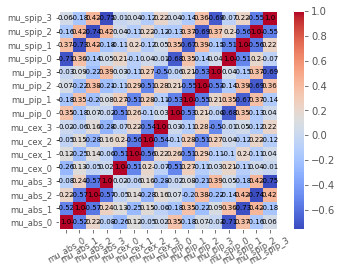

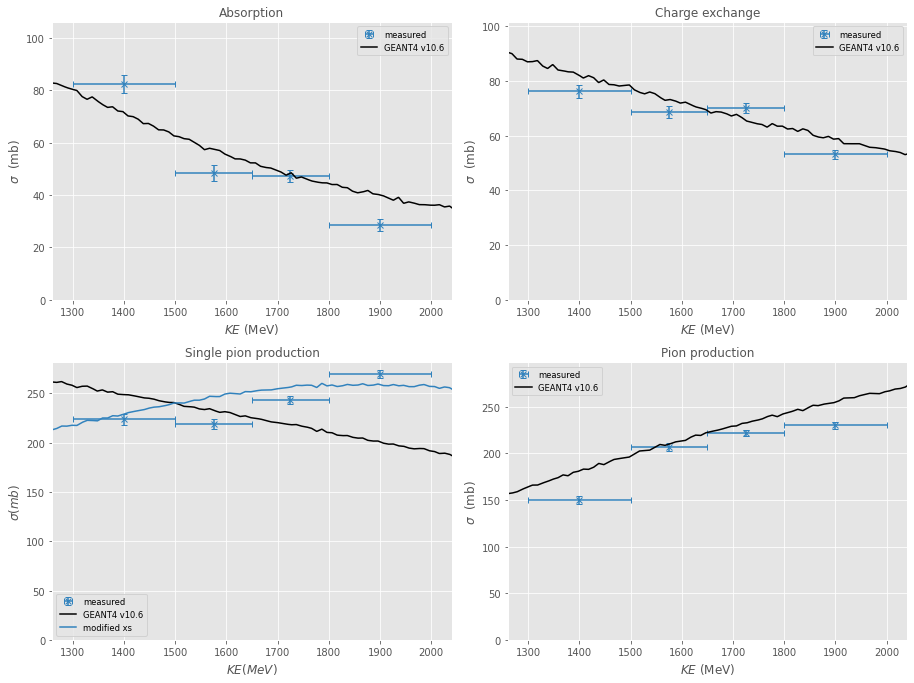

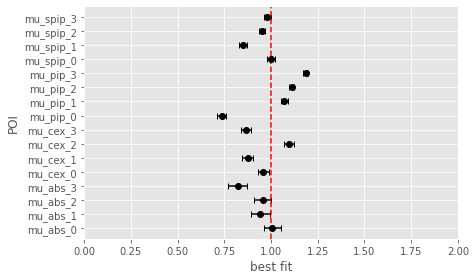

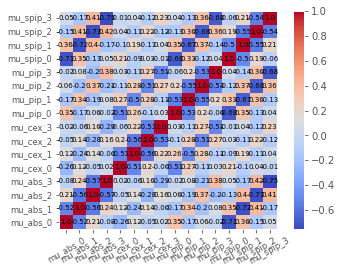

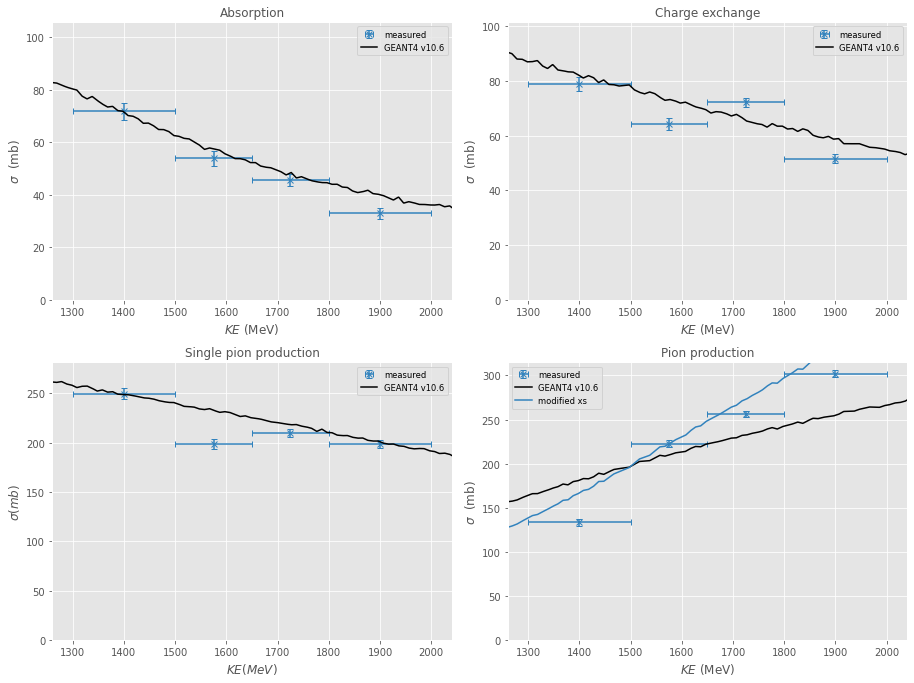

In [ ]:
xs_sim = cross_section.GeantCrossSections()

for t in toy_template.exclusive_process:
    mod_pdf = cex_fit_studies.CreateModifiedXS(xs_sim, t, 1.5, 0.5, 1500, 500)
    toy_obs = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(make_cfg(2, mod_pdf, int(1E5)))))
    toy_test(toy_template, toy_obs, true_bins, reco_bins, region_bins, mod_pdf)
